In [4]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from pathlib import Path
import random

#nilearn imports
from nilearn import plotting, image, interfaces
from nilearn.image import mean_img
from nilearn.plotting import plot_anat, plot_img, plot_stat_map, show, plot_design_matrix
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.reporting import get_clusters_table
import nilearn
import nibabel as nib

#sklearn imports
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

In [5]:
# loading all beta data together

def load_beta_data():
    
    X, y = [], []
    
    directory = Path("~/teams/a05/group_1_data/nonConfoundBeta/").expanduser()
    
    beta_files = list(directory.glob("beta_*.nii.gz"))

    for file_path in beta_files:
        
        file_name = file_path.stem
        subjID = file_name.split("_")[1]
        task = file_name.split("_")[2]

        beta_img = nib.load(str(file_path))
        beta_data = beta_img.get_fdata().flatten()
        
        X.append(beta_data)
        y.append(task)

    return np.array(X), np.array(y)

In [6]:
X, y = load_beta_data()

In [7]:
len(X[0])

902629

In [8]:
# Note - subjects 173B, 187B, 195B not included due to lack of preproc data
# subjects 112 and 113 are not included due to lack of events file data
# subject 145 is missing a run

print(f"Loaded {len(X)} runs")

Loaded 271 runs


In [9]:
# splitting data into 3 runs for train, 1 run for test per subject

def load_beta_data_custom_split():
    
    X_train, y_train = [], []
    X_test, y_test = [], []

    directory = Path("~/teams/a05/group_1_data/nonConfoundBeta/").expanduser()

    subject_runs = {}
    
    beta_files = list(directory.glob("beta_*.nii.gz"))

    for file_path in beta_files:
        file_name = file_path.stem
        parts = file_name.split("_")

        subjID = parts[1]
        task = parts[2]
        run = int(parts[3].split('.')[0])

        if (subjID, task) not in subject_runs:
            subject_runs[(subjID, task)] = []
        subject_runs[(subjID, task)].append((run, file_path))

    for (subjID, task), runs in subject_runs.items():

        if len(runs) == 4:

            train_runs = runs[:3]
            test_run = runs[3]
    
            # random.shuffle(runs)
            # train_runs = sorted(runs[:3])
            # test_run = runs[3]
    
            for run, file_path in train_runs:
                beta_img = nib.load(str(file_path))
                beta_data = beta_img.get_fdata().flatten()
    
                X_train.append(beta_data)
                y_train.append(task)
    
            run, file_path = test_run
            beta_img = nib.load(str(file_path))
            beta_data = beta_img.get_fdata().flatten()
    
            X_test.append(beta_data)
            y_test.append(task)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

In [10]:
X_train, y_train, X_test, y_test = load_beta_data_custom_split()
print(f"Train Samples: {len(X_train)}, Test Samples: {len(X_test)}")

Train Samples: 201, Test Samples: 67


In [11]:
unique, counts = np.unique(y_train, return_counts=True)
print('y_train counts: '), dict(zip(unique, counts))

y_train counts: 


(None, {'colorwheel': 99, 'samedifferent': 102})

In [12]:
unique, counts = np.unique(y_test, return_counts=True)
print('y_train counts: '), dict(zip(unique, counts))

y_train counts: 


(None, {'colorwheel': 33, 'samedifferent': 34})

In [10]:
# Logistic regression with random 80-20 split across all subjects/runs
def logistic_reg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Training on {len(X_train)} samples, Testing on {len(X_test)} samples")

    logreg_model = LogisticRegression()
    logreg_model.fit(X_train, y_train)
    y_pred = logreg_model.predict(X_test)

    y_pred_train = logreg_model.predict(X_train)  
    train_accuracy = accuracy_score(y_train, y_pred_train) 

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    return logreg_model

Training on 216 samples, Testing on 55 samples
Test Accuracy: 0.8000
Train Accuracy: 1.0000
Precision: 0.8011
Recall: 0.8000


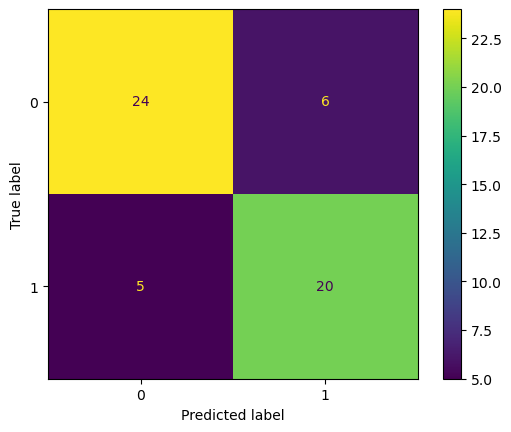

In [11]:
mod1 = logistic_reg(X, y)

In [12]:
# Logistic regression with 60/20/20 train/validation/test split and hyperparameter tuning

def train_logistic_reg(X, y):

    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

    print(f"Training on {len(X_train)} samples, Validating on {len(X_val)} samples, Testing on {len(X_test)} samples")

    param_grid = {'C': np.logspace(-2, 2, 5), 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}

    logreg = LogisticRegression(max_iter=500)
    rand_search = RandomizedSearchCV(logreg, param_distributions=param_grid, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
    rand_search.fit(X_train, y_train)

    best_model = rand_search.best_estimator_
    print(f"Best Hyperparameters: {rand_search.best_params_}")

    y_val_pred = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    y_test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    return best_model, val_accuracy, test_accuracy

Training on 162 samples, Validating on 54 samples, Testing on 55 samples
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0}
Validation Accuracy: 0.8889
Test Accuracy: 0.7273
Precision: 0.7327
Recall: 0.7273


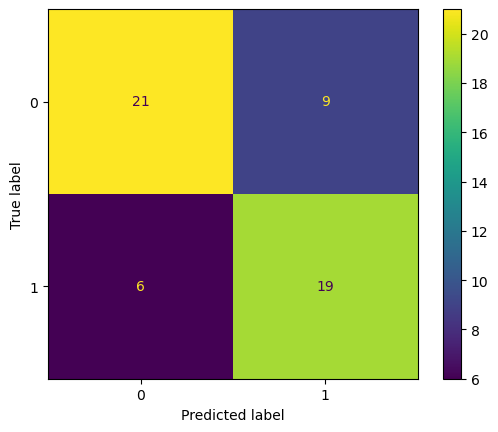

In [13]:
mod2 = train_logistic_reg(X, y)

In [14]:
# Logistic reg model for the custom 3 runs/1 run train/test split

def logistic_reg_custom(X_train, X_test, y_train, y_test):

    print(f"Training on {len(X_train)} samples, Testing on {len(X_test)} samples")

    logreg_model = LogisticRegression(max_iter=1000, random_state=42)
    logreg_model.fit(X_train, y_train)
    y_pred = logreg_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    y_pred_train = logreg_model.predict(X_train)  
    train_accuracy = accuracy_score(y_train, y_pred_train) 

    print(f"Model Accuracy: {accuracy:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    return logreg_model

Training on 201 samples, Testing on 67 samples
Model Accuracy: 0.9552
Train Accuracy: 1.0000
Precision: 0.9556
Recall: 0.9552


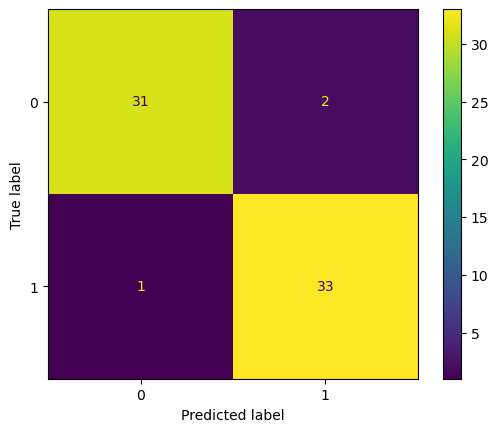

In [15]:
mod3 = logistic_reg_custom(X_train, X_test, y_train, y_test)

In [16]:
def logistic_shuffled(X_train, y_train, X_test, y_test):

    logreg = LogisticRegression(max_iter=1000, random_state=42)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    normal_acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy before shuffling: {normal_acc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    shuffled_y_train = np.random.permutation(y_train)
    shuffled_y_test = np.random.permutation(y_test)

    logreg_shuffled = LogisticRegression(max_iter=1000, random_state=42)
    logreg_shuffled.fit(X_train, shuffled_y_train)
    y_pred_shuffled = logreg_shuffled.predict(X_test)
    shuffled_acc = accuracy_score(shuffled_y_test, y_pred_shuffled)
    print(f"Accuracy after shuffling: {shuffled_acc:.4f}")

    cm = confusion_matrix(shuffled_y_test, y_pred_shuffled)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    if normal_acc > shuffled_acc + 0.2:
        print("The model is good")
    else:
        print("Overfitting or bias detected")

    return normal_acc, shuffled_acc

Accuracy before shuffling: 0.9552


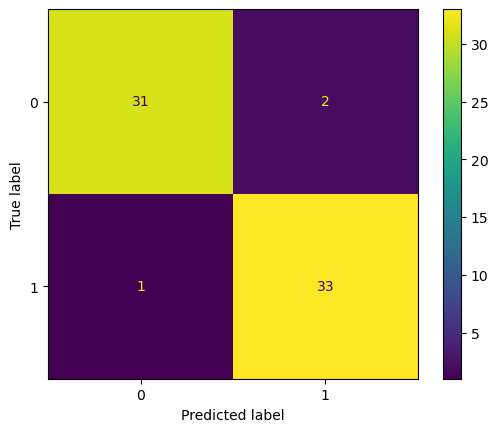

Accuracy after shuffling: 0.4627


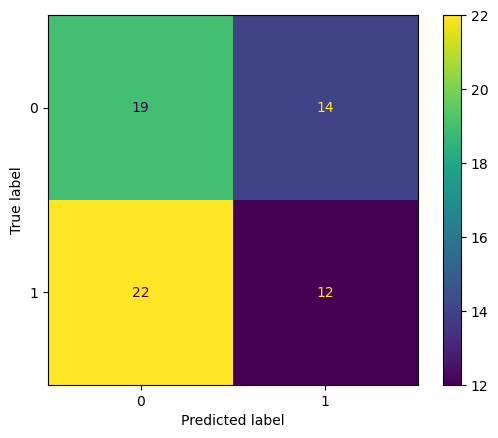

The model is good


In [17]:
normal_acc, shuffled_acc = logistic_shuffled(X_train, y_train, X_test, y_test)

In [30]:
def plot_subject_stat_maps(subjID, task1, task2, run=1):

    file_path_task1 = f"~/teams/a05/group_1_data/nonConfoundBeta/beta_{subjID}_{task1}_{run}.nii.gz"
    file_path_task2 = f"~/teams/a05/group_1_data/nonConfoundBeta/beta_{subjID}_{task2}_{run}.nii.gz"

    beta_img_task1 = nib.load(file_path_task1)
    beta_img_task2 = nib.load(file_path_task2)

    # cut_coords=(-65, 50) chosen because the MNI coordinates for intraparietal sulcus is 
    # x = -30, y = -65, z = 50 for the left hemisphere for the right
    # and x = 30, y = -65, z = 50 
    plotting.plot_stat_map(beta_img_task1, title=f"Subject {subjID} - Task: {task1}", 
                           vmax=2, alpha = 0.5, display_mode="yz", cut_coords=(-65, 50))
    plotting.plot_stat_map(beta_img_task2, title=f"Subject {subjID} - Task: {task2}", 
                           vmax=2, alpha = 0.5, display_mode="yz", cut_coords=(-65, 50))

    plotting.show()

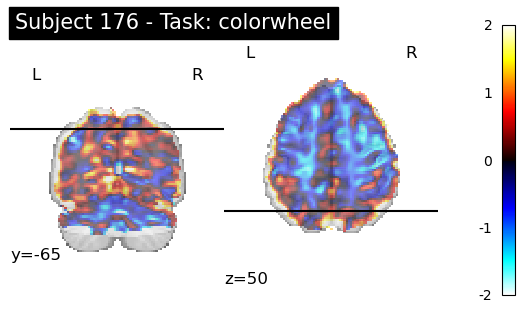

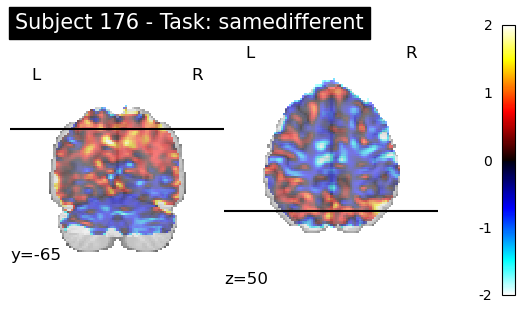

In [31]:
plot_subject_stat_maps(subjID=176, task1="colorwheel", task2="samedifferent", run=1)